In [1]:
import networkx as nx
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from qc_grader.graph_util import display_maxcut_widget, QAOA_widget, graphs
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit_optimization import QuadraticProgram
from typing import List
import plotly.graph_objects as go
import matplotlib as mpl
import pandas as pd
from IPython.display import clear_output
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.algorithms.optimizers import COBYLA, SLSQP, ADAM
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from time import time
from copy import copy
from qc_grader.graph_util import display_maxcut_widget, QAOA_widget, graphs
import math
from qiskit.visualization import plot_histogram
import operator
from collections import Counter



matplotlib.rcParams['figure.dpi'] = 100

Text(0.5, 1.0, 'dataset')

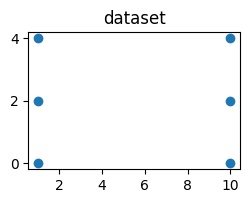

In [2]:
X = np.array([[1, 2], [1, 4], [1, 0],
            [10, 2], [10, 4], [10, 0]])
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1])
plt.title("dataset")

In [3]:
### Each point has an id
def get_points_dict(X):
    points = {}
    i = 0
    for p in X:
        points[i] = p
        i += 1
    num_points = i - 1
    return points

In [4]:
points = get_points_dict(X)

### Classical K-means

In [5]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

array([1, 1, 1, 0, 0, 0], dtype=int32)

In [6]:
y_pred = KMeans(n_clusters=2, random_state=0).fit_predict(X)

Text(0.5, 1.0, 'Classical Prediction')

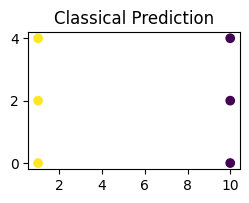

In [7]:
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Classical Prediction")

### Quantum K-means

#### Generate a graph from the points in the array

Each vertex representing a point on x-y plane and weights between the vertices is the distance between them

In [8]:
def graph_from_points(points):
    num_points = len(points)
    G = nx.Graph()
    edges = []
    for i in range(num_points):
        G.add_node(i, pos=tuple(points[i]))
        for j in range(num_points):
            if i == j: 
                continue
            edges.append((i, j, np.linalg.norm(points[i] - points[j])))

    G.add_weighted_edges_from(edges)
    return G

In [9]:
G = graph_from_points(points)

In [15]:
quadratic_program_from_graph(G)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: 31.439088914586 x_0 + 34.068402259089 x_1 + 34.068402259089 x_2
      + 31.439088914586 x_3 + 34.068402259089 x_4 + 34.068402259089 x_5 + [
      - 8 x_0*x_1 - 8 x_0*x_2 - 36 x_0*x_3 - 36.878177829172 x_0*x_4
      - 36.878177829172 x_0*x_5 - 16 x_1*x_2 - 36.878177829172 x_1*x_3
      - 36 x_1*x_4 - 39.395431207184 x_1*x_5 - 36.878177829172 x_2*x_3
      - 39.395431207184 x_2*x_4 - 36 x_2*x_5 - 8 x_3*x_4 - 8 x_3*x_5
      - 16 x_4*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End

In [11]:
pos=nx.get_node_attributes(G,'pos')
labels = nx.get_edge_attributes(G,'weight')

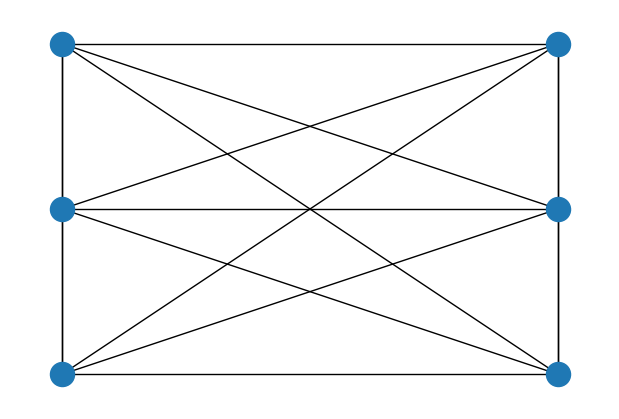

In [12]:
nx.draw(G,pos)

In [13]:
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

In [14]:
def maxcut_cost_fn(graph: nx.Graph, bitstring: List[int]) -> float:
    """
    Computes the maxcut cost function value for a given graph and cut represented by some bitstring
    Args:
        graph: The graph to compute cut values for
        bitstring: A list of integer values '0' or '1' specifying a cut of the graph
    Returns:
        The value of the cut
    """
    #Get the weight matrix of the graph
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    size = weight_matrix.shape[0]
    value = 0.

    #INSERT YOUR CODE TO COMPUTE THE CUT VALUE HERE
    set_zero = []
    set_one = []
    for i, bit_value in enumerate(bitstring):
        if (bit_value == 0):
            set_zero.append(i)
        else:
            set_one.append(i)
    for i in set_zero:
        for j in set_one:
            value += weight_matrix[i, j]
    return value

def plot_maxcut_histogram(graph: nx.Graph) -> None:
    """
    Plots a bar diagram with the values for all possible cuts of a given graph.
    Args:
        graph: The graph to compute cut values for
    """
    num_vars = graph.number_of_nodes()
    #Create list of bitstrings and corresponding cut values
    bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
    values = [maxcut_cost_fn(graph = graph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]
    #Sort both lists by largest cut value
    values, bitstrings = zip(*sorted(zip(values, bitstrings)))
    #Plot bar diagram
    bar_plot = go.Bar(x = bitstrings, y = values, marker=dict(color=values, colorscale = 'plasma', colorbar=dict(title='Cut Value')))
    fig = go.Figure(data=bar_plot, layout = dict(xaxis=dict(type = 'category'), width = 1500, height = 600))
    fig.show()
    
def qaoa_circuit(qubo: QuadraticProgram, p: int = 1):
    """
    Given a QUBO instance and the number of layers p, constructs the corresponding parameterized QAOA circuit with p layers.
    Args:
        qubo: The quadratic program instance
        p: The number of layers in the QAOA circuit
    Returns:
        The parameterized QAOA circuit
    """
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()

    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)

    #Outer loop to create each layer
    for i in range(p):

        #Apply R_Z rotational gates from cost layer
        #INSERT YOUR CODE HERE
        # The rz gates below can be commented out as well. As mentioned above, for Maxcut, single rz gate angle is 0.
        for j in range(size):
            qaoa_circuit.rz((qubo_linearity[j] + sum(qubo_matrix[j]))*1.0*gammas[i], j)

        #Apply R_ZZ rotational gates for entangled qubit rotations from cost layer
        #INSERT YOUR CODE HERE
        for j in range(size):
            for k in range(size):
                if (j == k):
                    continue
                qaoa_circuit.rzz(0.5*qubo_matrix[j,k]*gammas[i], j, k)

        # Apply single qubit X - rotations with angle 2*beta_i to all qubits
        #INSERT YOUR CODE HERE
        for j in range(size):
            qaoa_circuit.rx(2.*betas[i], j)

    return qaoa_circuit

def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    """Constructs a quadratic program from a given graph for a MaxCut problem instance.
    Args:
        graph: Underlying graph of the problem.
    Returns:
        QuadraticProgram
    """
    #Get weight matrix of graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] -= weight_matrix[i, j]
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += weight_matrix[i,j]

    #INSERT YOUR CODE HERE
    quadratic_program = QuadraticProgram('')
    for i in range(size):
        name = 'x_' + str(i)
        quadratic_program.binary_var(name = name)
#     print(qubo_vector)
    quadratic_program.maximize(quadratic = qubo_matrix, linear = qubo_vector.T, constant=0)
    
    
    return quadratic_program

def get_qoao_result(G, simulator='statevector_simulator'):
    backend = Aer.get_backend(simulator)
    qaoa = QAOA(optimizer = ADAM(), quantum_instance = backend, reps=1, initial_point = [0.1,0.1])
    eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
    quadratic_program = quadratic_program_from_graph(G)
    print("succesfully created a quadratic program")
    start_time = time()
    result = eigen_optimizer.solve(quadratic_program)
    end_time = time()
    print("Time taken: ", end_time - start_time)
    print(result)
    return result

def plot_qaoa_energy_landscape(graph: nx.Graph, p, cvar: float = None):
    start_time = time()
    num_shots = 1000
    seed = 42
    simulator = Aer.get_backend('qasm_simulator')
    simulator.set_options(seed_simulator = 42)

    #Generate circuit
    circuit = qaoa_circuit(qubo = quadratic_program_from_graph(graph), p=p)
    circuit.measure(range(graph.number_of_nodes()),range(graph.number_of_nodes()))

    #Create dictionary with precomputed cut values for all bitstrings 
    cut_values = {}
    size = graph.number_of_nodes()
    for i in range(2**size):
        bitstr = '{:b}'.format(i).rjust(size, '0')[::-1]
        x = [int(bit) for bit in bitstr]
        cut_values[bitstr] = maxcut_cost_fn(graph, x)

    #Perform grid search over all parameters
    data_points = []
    max_energy = None
    for beta in np.linspace(0,np.pi, 50):
        for gamma in np.linspace(0, 4*np.pi, 50):
            bound_circuit = circuit.assign_parameters([beta, gamma])
            result = simulator.run(bound_circuit, shots = num_shots).result()
            statevector = result.get_counts(bound_circuit)
            energy = 0
            measured_cuts = []
            for bitstring, count in statevector.items():
                measured_cuts =  measured_cuts + [cut_values[bitstring]]*count

            if cvar is None:
                #Calculate the mean of all cut values
                energy = sum(measured_cuts)/num_shots
            else:
                energy = 0
                cvar_measured_cuts = sorted(measured_cuts, reverse=True)
                cvar_ceil = np.math.ceil(cvar*num_shots)
                for i in range(cvar_ceil):
                    energy += cvar_measured_cuts[i]
                energy /= cvar_ceil

            #Update optimal parameters
            if max_energy is None or energy > max_energy:
                max_energy = energy
                optimum = {'beta': beta, 'gamma': gamma, 'energy': energy}

            #Update data
            data_points.append({'beta': beta, 'gamma': gamma, 'energy': energy})


    #Create and display surface plot from data_points
#     df = pd.DataFrame(data_points)
#     df = df.pivot(index='beta', columns='gamma', values='energy')
#     matrix = df.to_numpy()
#     beta_values = df.index.tolist()
#     gamma_values = df.columns.tolist()

#     surface_plot = go.Surface(
#         x=gamma_values, 
#         y=beta_values,
#         z=matrix,
#         coloraxis = 'coloraxis'
#     )
#     fig = go.Figure(data = surface_plot)
#     fig.show()
    end_time = time()
    print ("time taken: ", end_time - start_time)
    #Return optimum
    return optimum

def get_top_5_bitstrings(backend, G, p):
    
    backend.shots = 1000

    circuit = qaoa_circuit(qubo = quadratic_program_from_graph(G), p=p)
    circuit.measure(range(G.number_of_nodes()),range(G.number_of_nodes()))
    bound_circuit = circuit.assign_parameters([result['beta'], result['gamma']])

    counts = backend.run(bound_circuit, seed_simulator=10).result().get_counts()

    k = Counter(counts)
    top_5 = k.most_common(5)
    return top_5

In [160]:
result = plot_qaoa_energy_landscape(G, p=1)
print(result)

time taken:  12.190848112106323
{'beta': 0.5770272220879211, 'gamma': 0.2564565431501872, 'energy': 67.43477608651823}


In [162]:
backend = Aer.get_backend('qasm_simulator')
top_5 = get_top_5_bitstrings(backend, G, p=1)
top_5

[('111000', 286),
 ('000111', 268),
 ('111110', 24),
 ('001000', 22),
 ('000001', 22)]

[1, 1, 1, 0, 0, 0]


Text(0.5, 1.0, 'Quantum Prediction')

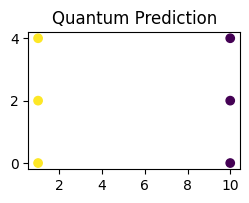

In [163]:
y_pred = list(map(int, top_5[0][0]))
print(y_pred)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Quantum Prediction")

### Performance on Blobs dataset - 2 centers

In [164]:
from sklearn.datasets import make_blobs

In [165]:
n_samples = 10
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=2)

Text(0.5, 1.0, 'Classical K-means')

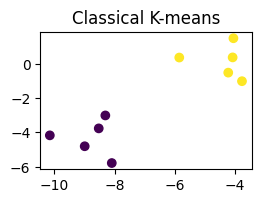

In [166]:
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Classical K-means")

### Quantum K-means

time taken:  25.138373851776123
{'beta': 1.4105109873260295, 'gamma': 0.5129130863003744, 'energy': 100.2811484107987}
[('0011110011', 9), ('1110100000', 8), ('0011111001', 8), ('1010000110', 7), ('1000011110', 7)]


Text(0.5, 1.0, 'Quantum Prediction')

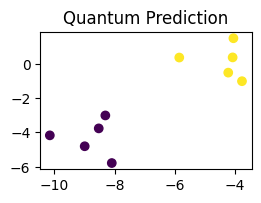

In [167]:
points = get_points_dict(X)
G = graph_from_points(points)
result = plot_qaoa_energy_landscape(G, p=1)
print(result)
backend = Aer.get_backend('qasm_simulator')
top_5 = get_top_5_bitstrings(backend, G, p=1)
print(top_5)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Quantum Prediction")

### 30 data points

In [168]:
n_samples = 30
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=2)

In [169]:
points = get_points_dict(X)
G = graph_from_points(points)
result = plot_qaoa_energy_landscape(G, p=1)
print(result)
backend = Aer.get_backend('qasm_simulator')
top_5 = get_top_5_bitstrings(backend, G, p=1)
print(top_5)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Quantum Prediction")

KeyboardInterrupt: 

### Performance on blobs dataset - 3 centers

In [119]:
n_samples = 10
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=3)

Text(0.5, 1.0, 'Incorrect Number of Blobs')

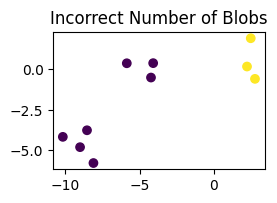

In [120]:
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

Text(0.5, 1.0, 'Correct Number of Blobs')

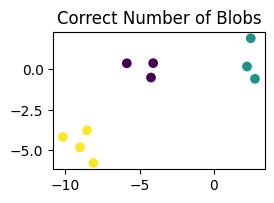

In [121]:
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Correct Number of Blobs")

### Quantum Prediction

succesfully created a quadratic program
Time taken:  21.87635087966919
optimal function value: 233.18212870888854
optimal value: [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
status: SUCCESS


Text(0.5, 1.0, 'Quantum Prediction')

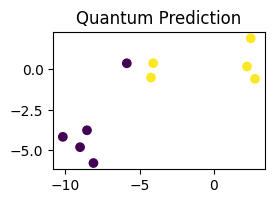

In [122]:
points = get_points_dict(X)
G = graph_from_points(points)
result = get_qoao_result(G, simulator='statevector_simulator')
y_pred = result.x
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Quantum Prediction")

### Run quantum algo on real quantum devices and qasm simulator

In [190]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=1000):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [191]:
from scipy.optimize import minimize

expectation = get_expectation(G, p=1)

res = minimize(expectation, [0.1,0.1], method='COBYLA')
res

     fun: -8.59375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 37
  status: 1
 success: True
       x: array([1.33934913, 0.20752812])

In [192]:
backend = Aer.get_backend('qasm_simulator')
backend.shots = 1000

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()


In [193]:
max(counts.items(), key=operator.itemgetter(1))[0]

'101010'

In [194]:
counts['101010']

50

In [176]:
a = np.sqrt(0.85**2 + 0.36**2)

In [179]:
0.36/a

0.38999336475266994

In [182]:
a = 0.141 + 0.866
b = 0.990 + 0.500
(a**2 + b**2)/4

0.8085372499999999

In [183]:
a = 0.141 - 0.866
b = 0.990 - 0.500
1 - (a**2 + b**2)/4

0.8085687500000001